In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=5):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]

    node_positions2 = [(80, 40),
                       (0, 40),
                       (0, 80),
                       (80, 80),
                       (0, 0),
                       (80, 0),
                       ]
    edges = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]

    track_graph1 = make_track_graph(node_positions1, edges)
    track_graph2 = make_track_graph(node_positions2, edges)
    
    traversal_path = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0), (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path, track_graph1)
    position2 = generate_position(traversal_path, track_graph2)
    
    edge_order = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order,
                                           edge_spacing=edge_spacing,
                                           use_HMM=False)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order,
                                          edge_spacing=edge_spacing,
                                          use_HMM=False)
    
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    place_field_centers2 = generate_position(traversal_path, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)

    
    spikes2 = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order, edge_spacing
           )

In [3]:
(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order, edge_spacing
) = make_two_environment_data()

In [4]:

def plot_wtrack1_outline(ax=None):
    if ax is None:
        ax = plt.gca()

    ax.plot([40 + 5, 40 + 5], [80 + 5, 0 + 5], color='black')
    ax.plot([40 - 5, 40 - 5], [80 + 5, 0 + 5], color='black')
    ax.plot([40 - 5, 40 + 5], [80 + 5, 80 + 5], color='black')

    ax.plot([0 + 5, 0 + 5], [80 + 5, 0 + 5], color='black')
    ax.plot([0 - 5, 0 - 5], [80 + 5, 0 - 5], color='black')
    ax.plot([0 - 5, 0 + 5], [80 + 5, 80 + 5], color='black')

    ax.plot([80 + 5, 80 + 5], [80 + 5, 0 - 5], color='black')
    ax.plot([80 - 5, 80 - 5], [80 + 5, 0 + 5], color='black')
    ax.plot([80 - 5, 80 + 5], [80 + 5, 80 + 5], color='black')

    ax.plot([0 - 5, 80 + 5], [0 - 5, 0 - 5], color='black')
    ax.plot([0 + 5, 40 - 5], [0 + 5, 0 + 5], color='black')
    ax.plot([40 + 5, 80 - 5], [0 + 5, 0 + 5], color='black')
    
    ax.text(0, 80 + 8, 'L', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(40, 80 + 8, 'C', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(80, 80 + 8, 'R', fontweight='bold', fontsize=24, ha='center', va='center')
    
def plot_wtrack2_outline(ax=None):
    if ax is None:
        ax = plt.gca()

    ax.plot([80 + 5, 0 + 5], [40 + 5, 40 + 5], color='black')
    ax.plot([80 + 5, 0 + 5], [40 - 5, 40 - 5], color='black')
    ax.plot([80 + 5, 80 + 5], [40 - 5, 40 + 5], color='black')

    ax.plot([80 + 5, 0 + 5], [0 + 5, 0 + 5], color='black')
    ax.plot([80 + 5, 0 - 5], [0 - 5, 0 - 5], color='black')
    ax.plot([80 + 5, 80 + 5], [0 - 5, 0 + 5], color='black')

    ax.plot([80 + 5, 0 - 5], [80 + 5, 80 + 5], color='black')
    ax.plot([80 + 5, 0 + 5], [80 - 5, 80 - 5], color='black')
    ax.plot([80 + 5, 80 + 5], [80 - 5, 80 + 5], color='black')

    ax.plot([0 - 5, 0 - 5], [0 - 5, 80 + 5], color='black')
    ax.plot([0 + 5, 0 + 5], [0 + 5, 40 - 5], color='black')
    ax.plot([0 + 5, 0 + 5], [40 + 5, 80 - 5], color='black')
    
    ax.text(80 + 8, 0, 'R', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(80 + 8, 40, 'C', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(80 + 8, 80, 'L', fontweight='bold', fontsize=24, ha='center', va='center')

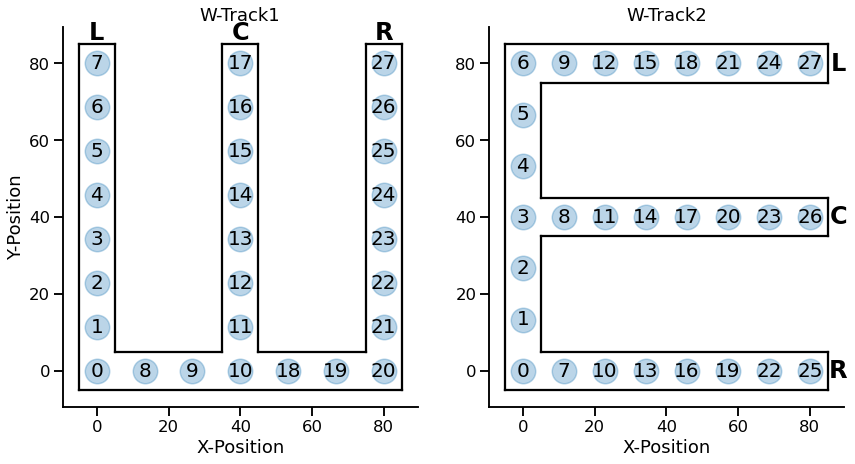

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0.3, s=600, zorder=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[0].set_title('W-Track1')
axes[0].set_ylabel('Y-Position')
axes[0].set_xlabel('X-Position')
plot_wtrack1_outline(ax=axes[0])
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0.3, s=600, zorder=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[1].set_title('W-Track2')
axes[1].set_xlabel('X-Position')
plot_wtrack2_outline(ax=axes[1])

sns.despine()

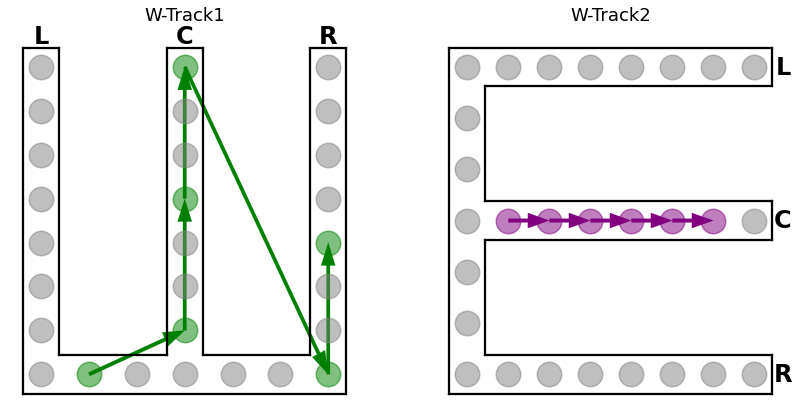

In [6]:
def plot_2D_place_field_sequence(sequence):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    for ind, center in enumerate(place_field_centers1):
        if ind in sequence:
            axes[0].scatter(place_field_centers1[ind, 0], place_field_centers1[ind, 1], alpha=0.5, s=600, zorder=0, color='green')
        else:
            axes[0].scatter(place_field_centers1[ind, 0], place_field_centers1[ind, 1], alpha=0.5, s=600, zorder=0, color='grey')
    
    for ind1, ind2 in zip(sequence[:-1], sequence[1:]):
        axes[0].arrow(place_field_centers1[ind1, 0],
                      place_field_centers1[ind1, 1],
                      place_field_centers1[ind2, 0] - place_field_centers1[ind1, 0],
                      place_field_centers1[ind2, 1] - place_field_centers1[ind1, 1],
                      width=1,
                      head_width=4,
                      alpha=1,
                      color='green',
                      zorder=-1,
                      linewidth=0.1,
                      length_includes_head=True
                     )
        
    axes[0].set_title('W-Track1', pad=10)
    axes[0].axis('off')
    plot_wtrack1_outline(ax=axes[0])

    for ind, center in enumerate(place_field_centers2):
        if ind in sequence:
            axes[1].scatter(place_field_centers2[ind, 0], place_field_centers2[ind, 1], alpha=0.5, s=600, zorder=0, color='purple')
        else:
            axes[1].scatter(place_field_centers2[ind, 0], place_field_centers2[ind, 1], alpha=0.5, s=600, zorder=0, color='grey')
        
    for ind1, ind2 in zip(sequence[:-1], sequence[1:]):
        axes[1].arrow(place_field_centers2[ind1, 0],
                      place_field_centers2[ind1, 1],
                      place_field_centers2[ind2, 0] - place_field_centers2[ind1, 0],
                      place_field_centers2[ind2, 1] - place_field_centers2[ind1, 1],
                      width=1,
                      head_width=4,
                      alpha=1,
                      color='purple',
                      zorder=-1,
                      linewidth=0.1,
                      length_includes_head=True
                     )
    axes[1].set_title('W-Track2', pad=10)
    axes[1].axis('off')
    plot_wtrack2_outline(ax=axes[1])
    sns.despine()
    
sequence = [8, 11, 14, 17, 20, 23]
plot_2D_place_field_sequence(sequence)

(-8.4, 88.4, -8.4, 88.4)

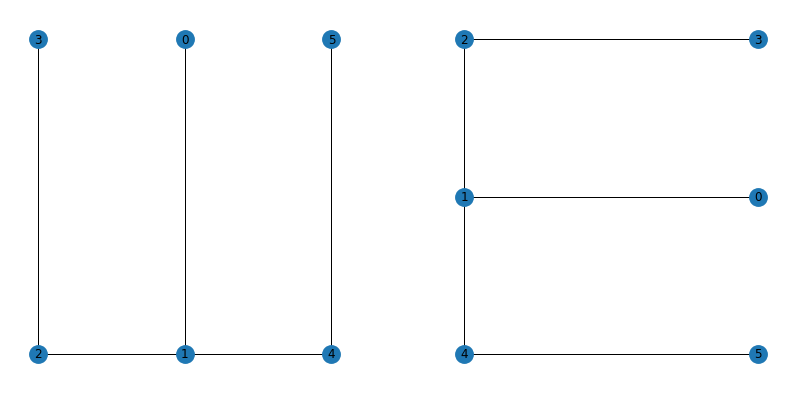

In [7]:
from track_linearization import plot_track_graph

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
plot_track_graph(track_graph1, ax=axes[0])
axes[0].axis('off')
plot_track_graph(track_graph2, ax=axes[1])
axes[1].axis('off')

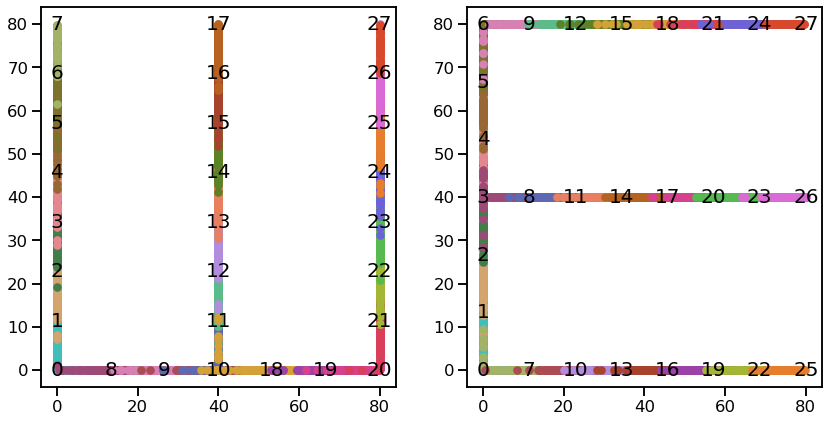

In [8]:
colors = ["#609ed8",
"#3fbfbc",
"#d4a46d",
"#427d4a",
"#e5878e",
"#996733",
"#7c722b",
"#a2b367",
"#9e4a76",
"#d680b4",
"#ab4b54",
"#5f69b3",
"#5bbc89",
"#b28cdd",
"#e77f60",
"#5b8225",
"#a7432c",
"#b66221",
"#d4a038",
"#9a42a8",
"#d6418d",
"#db3e5b",
"#a3b734",
"#56ba50",
"#6d63d7",
"#e67e2d",
"#d96ad6",
"#d8492c"]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, (center, spike) in enumerate(zip(place_field_centers1, spikes1.T)):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    axes[0].scatter(position1[spike.astype(bool), 0], position1[spike.astype(bool), 1], c=colors[ind], s=50)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, (center, spike) in enumerate(zip(place_field_centers2, spikes2.T)):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    axes[1].scatter(position2[spike.astype(bool), 0], position2[spike.astype(bool), 1], c=colors[ind], s=50)

In [9]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform
from replay_trajectory_classification.observation_model import ObservationModel

environments = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing),
    Environment('wtrack2', track_graph=track_graph2, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types = [[RandomWalk('wtrack1', movement_var=6.0),         Uniform('wtrack1', 'wtrack2')],
                               [Uniform('wtrack2', 'wtrack1'), RandomWalk('wtrack2', movement_var=6.0)]]

environment_names_to_state = ['wtrack1', 'wtrack2']
observation_models = [ObservationModel('wtrack1'), ObservationModel('wtrack2')]

classifier = SortedSpikesClassifier(
    environments=environments,
    observation_models=observation_models,
    continuous_transition_types=continuous_transition_types,
)
classifier

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0,...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=[ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack2', encoding_group=0)],
                       sorted_spikes_algorithm='spiking_likelihood_kde',
                       sorted_spikes_algorithm_params={'block_siz

In [10]:
position = np.concatenate((position_df1.linear_position.values,
                           position_df2.linear_position.values))
spikes = np.concatenate((spikes1, spikes2))
environment_labels = np.concatenate((['wtrack1'] * spikes1.shape[0],
                                     ['wtrack2'] * spikes2.shape[0],
                                    ))
classifier.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0,...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=[ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack2', encoding_group=0)],
                       sorted_spikes_algorithm='spiking_likelihood_kde',
                       sorted_spikes_algorithm_params={'block_siz

In [11]:
def make_sequence(neuron_sequence, n_neurons=28, step=1):
    neuron_sequence = np.asarray(neuron_sequence)
    n_time = step * len(neuron_sequence)
    spike_time_ind = np.arange(0, n_time, step)
    spikes = np.zeros((n_time, n_neurons))
    
    spikes[(spike_time_ind, neuron_sequence)] = 1
    
    return spikes

In [12]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments2 = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types2 = [[RandomWalk('wtrack1', movement_var=6.0), Uniform('wtrack1')],
                                [Uniform('wtrack1'),    Uniform('wtrack1')]]

classifier2 = SortedSpikesClassifier(
    environments=environments2,
    continuous_transition_types=continuous_transition_types2,
)
classifier2.fit(
    position=position_df1.linear_position.values,
    spikes=spikes1,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)],
                                                    [Uniform(environment_name='wtrack1', environment2_name=None),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)]],
                       discrete_transition_ty...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack1', encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_kde',
                       sorted_spikes_algor

In [13]:
def plot_one_env_results(results):
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(7, 8 / 2), sharex=True)
    (results
     .acausal_posterior
     .sum('position')
     .assign_coords(time=lambda ds: ds.time / 1000)
     .plot(x='time', hue='state', ax=ax))
    ax.set_ylim((0, 1))
    ax.set_xlim((results.time[0] / 1000, results.time[-1] / 1000))
    ax.set_ylabel('Prob.')
    sns.despine()

In [14]:
import copy
from cycler import cycler

def plot_replay_results(test_spikes, classifier, results):
    time = np.arange(test_spikes.shape[0])
    fig, axes = plt.subplots(5, 1, constrained_layout=True, figsize=(7, 8), sharex=True)
    mask1 = ~classifier.environments[0].is_track_interior_
    mask1 = mask1.astype(float)
    mask1[mask1 == 1] = np.nan
    mask1[mask1 == 0] = 1
    mask1 = mask1[:, np.newaxis]

    mask2 = ~classifier.environments[1].is_track_interior_
    mask2 = mask2.astype(float)
    mask2[mask2 == 1] = np.nan
    mask2[mask2 == 0] = 1
    mask2 = mask2[:, np.newaxis]
    
    w_track1_cmap = copy.copy(plt.cm.get_cmap('Greens'))
    w_track1_cmap.set_bad(color="lightgrey", alpha=0.8)
    
    w_track2_cmap = copy.copy(plt.cm.get_cmap('Purples'))
    w_track2_cmap.set_bad(color="lightgrey", alpha=0.8)
    
    time_ind, spike_ind = np.nonzero(test_spikes)
    
    # Spikes sorted according to w-track 1 place fields
    w_track1_sort_order = np.argsort(np.asarray(
        get_linearized_position(place_field_centers1,
                                track_graph1,
                                edge_order=edge_order,
                                edge_spacing=edge_spacing,
                                use_HMM=False).linear_position))
    w_track1_sort_order = {cell_id: order for order, cell_id in enumerate(w_track1_sort_order)}
    

    axes[0].scatter(time[time_ind], [w_track1_sort_order[i] for i in spike_ind], clip_on=False, color='green', s=50)
    axes[0].set_ylim((-1, 29))
    axes[0].set_yticks((0, 28))
    axes[0].set_yticklabels((1, 29))
    axes[0].set_ylabel('Cells')
    axes[0].set_title('Ordered according to W-Track 1 Place Fields')
    
    # Spikes sorted according to w-track 2 place fields
    w_track2_sort_order = np.argsort(np.asarray(get_linearized_position(place_field_centers2,
                 track_graph2,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 use_HMM=False).linear_position))
    w_track2_sort_order = {cell_id: order for order, cell_id in enumerate(w_track2_sort_order)}

    axes[1].scatter(time[time_ind], [w_track2_sort_order[i] for i in spike_ind], clip_on=False, color='purple', s=50)
    axes[1].set_ylim((-1, 29))
    axes[1].set_yticks((0, 28))
    axes[1].set_yticklabels((1, 29))
    axes[1].set_ylabel('Cells')
    axes[1].set_title('Ordered according to W-Track 2 Place Fields')
    
    # Probabilities
    axes[2].set_prop_cycle(cycler(color=['green', 'purple']))
    prob = results['acausal_posterior'].sum(axis=2)
    axes[2].plot(time, results['acausal_posterior'].sum(axis=2),
                 label=['W-Track 1', 'W-Track 2'], clip_on=False)
    axes[2].text(time[-1], prob.isel(time=-1, state=0), 'W-Track 1', color='green', va='center', ha='left', fontsize=14)
    axes[2].text(time[-1], prob.isel(time=-1, state=1), 'W-Track 2', color='purple', va='center', ha='left', fontsize=14)
    axes[2].set_ylim((0, 1))
    axes[2].set_yticks((0, 1))
    axes[2].set_yticklabels((0, 1))
    axes[2].set_ylabel('Prob.\nof Env.')
    
    # W-Track 1 posterior
    t, x = np.meshgrid(np.append(time, time[-1] + 1/1000), classifier.environments[0].edges_[0])
    axes[3].pcolormesh(t, x, results['acausal_posterior'][:, 0].T * mask1,
                       cmap=w_track1_cmap, vmin=0.0, vmax=0.1)
    axes[3].set_ylim((0, int(x.max())))
    axes[3].set_yticks((0, int(x.max())))
    axes[3].set_yticklabels((0, int(x.max())))

    axes[3].set_title('Prob. of W-Track 1 Position')
    axes[3].set_ylabel('Position')
    
    arm_node_positions = np.asarray(
        get_linearized_position(np.asarray([track_graph1.nodes[node_id]['pos'] for node_id in [3, 0, 5]]),
                         track_graph1,
                         edge_order=edge_order,
                         edge_spacing=edge_spacing,
                         use_HMM=False).linear_position)
    for arm_label, arm_pos in zip(['L', 'C', 'R'], arm_node_positions):
        va = 'bottom' if arm_label == 'C' else 'top'
        axes[3].text(time[-1] + 1/1000, arm_pos, arm_label, va=va, ha='left', fontweight='bold')
    
    # W-Track 2 posterior
    t, x = np.meshgrid(np.append(time, time[-1] + 1/1000), classifier.environments[1].edges_[0])
    n_position_bins = classifier.environments[1].is_track_interior_.shape[0]
    axes[4].pcolormesh(t, x, results['acausal_posterior'][:, 1, :n_position_bins].T * mask2,
                       cmap=w_track2_cmap, vmin=0.0, vmax=0.1)
    axes[4].set_title('Prob. of W-Track 2 Position')
    axes[4].set_ylim((0, int(x.max())))
    axes[4].set_yticks((0, int(x.max())))
    axes[4].set_yticklabels((0, int(x.max())))
    axes[4].set_ylabel('Position') 
    arm_node_positions = np.asarray(
        get_linearized_position(np.asarray([track_graph2.nodes[node_id]['pos'] for node_id in [3, 0, 5]]),
                         track_graph2,
                         edge_order=edge_order,
                         edge_spacing=edge_spacing,
                         use_HMM=False).linear_position)
    for arm_label, arm_pos in zip(['L', 'C', 'R'], arm_node_positions):
        va = 'bottom' if arm_label == 'C' else 'top'
        axes[4].text(time[-1] + 1/1000, arm_pos, arm_label, va=va, ha='left', fontweight='bold')
    

    axes[4].set_xlabel('Time [ms]')
    axes[4].set_xlim((time[0], time[-1]))
    axes[4].set_xticks((time[0], time[-1]))
    axes[4].set_xticklabels((time[0], time[-1]))
    sns.despine()

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


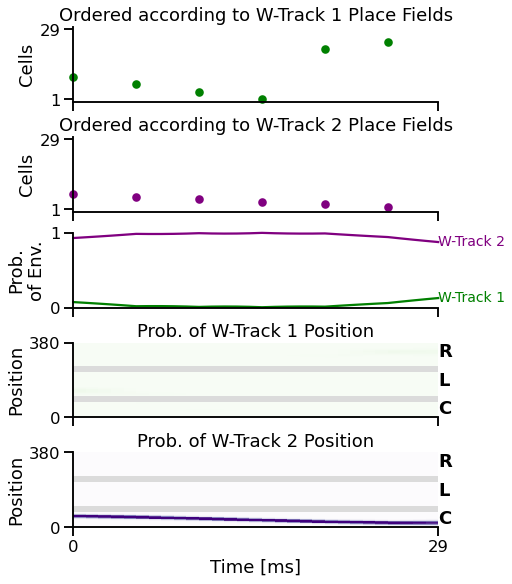

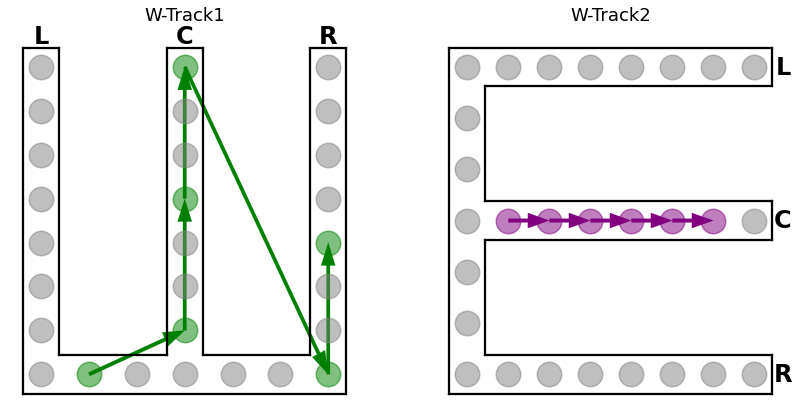

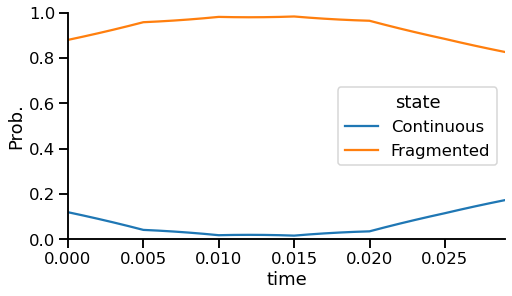

In [15]:
sequence = [8, 11, 14, 17, 20, 23]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


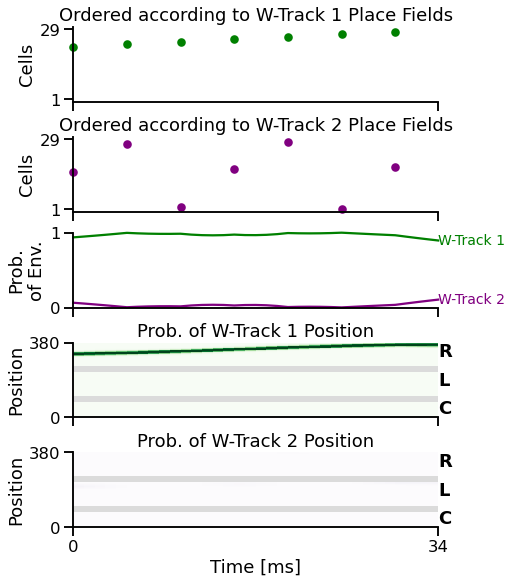

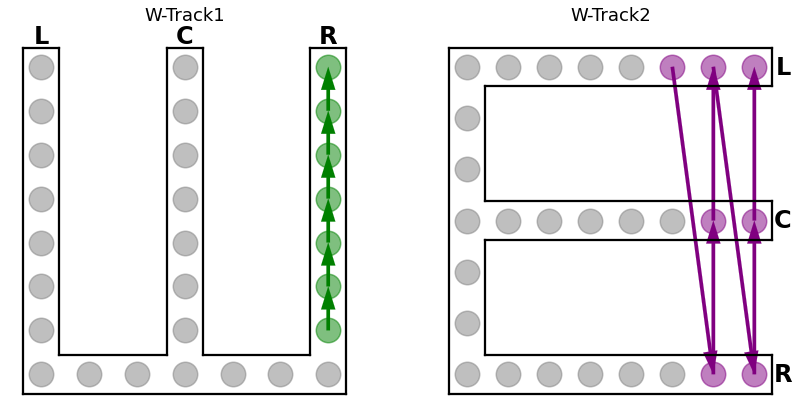

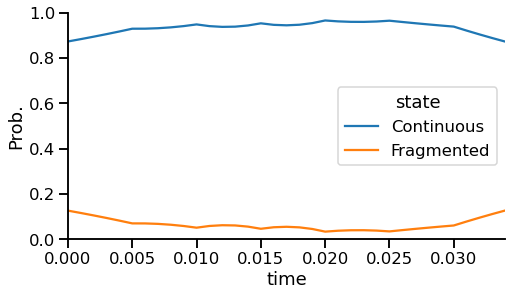

In [16]:
sequence = [21, 22, 23, 24, 25, 26, 27]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


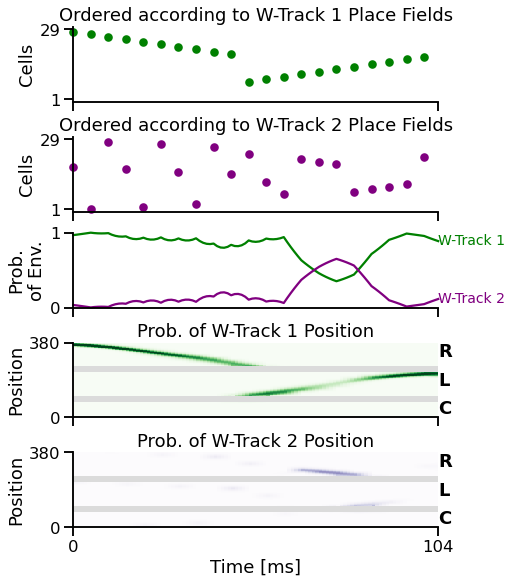

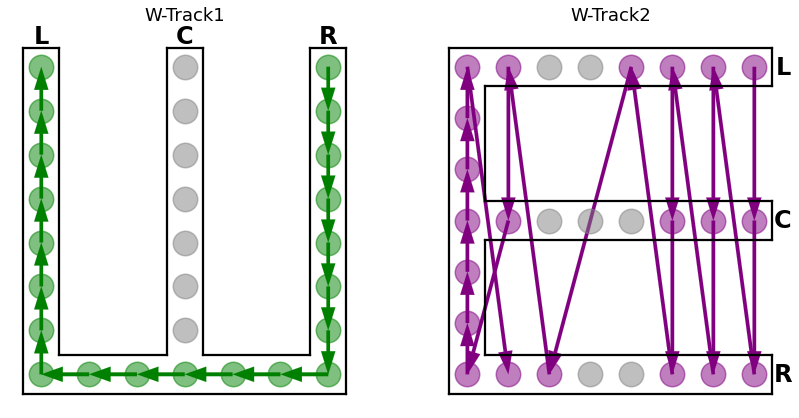

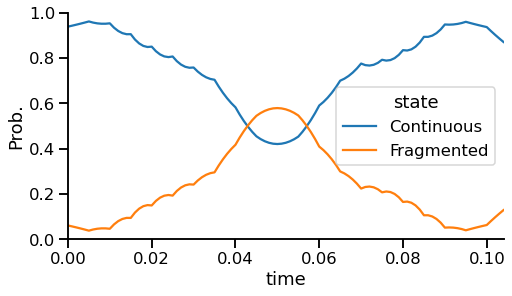

In [17]:
sequence = [27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 10, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


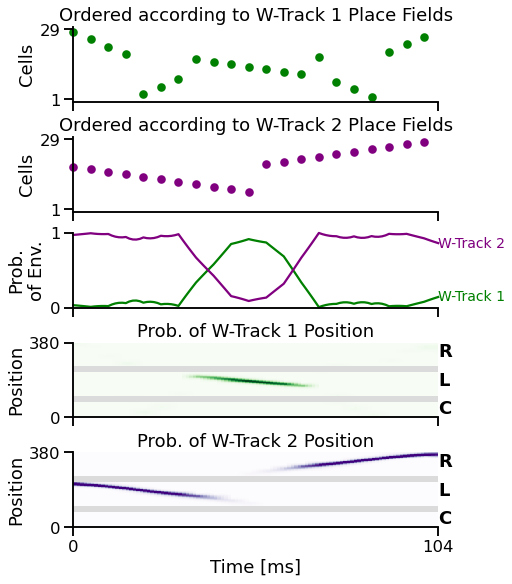

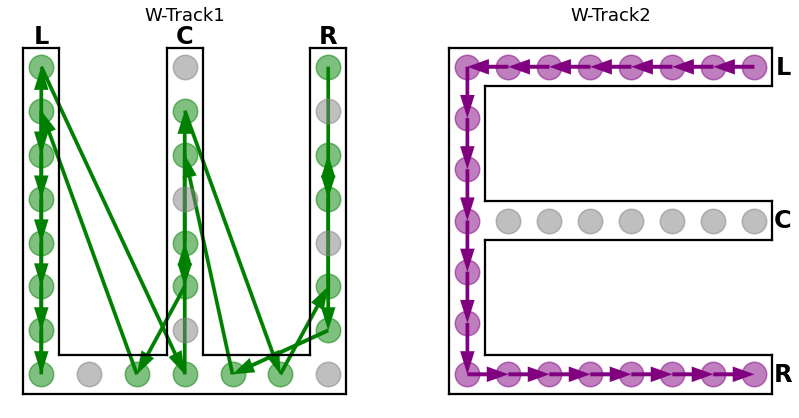

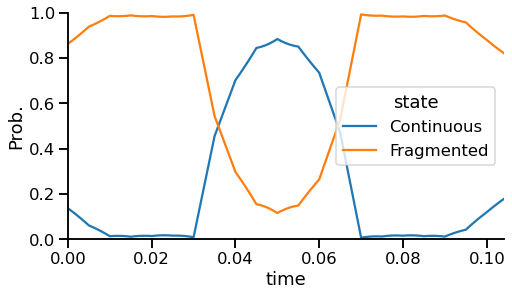

In [18]:
sequence = [27, 24, 21, 18, 15, 12, 9, 6, 5, 4, 3, 2, 1, 0, 7, 10, 13, 16, 19, 22, 25]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


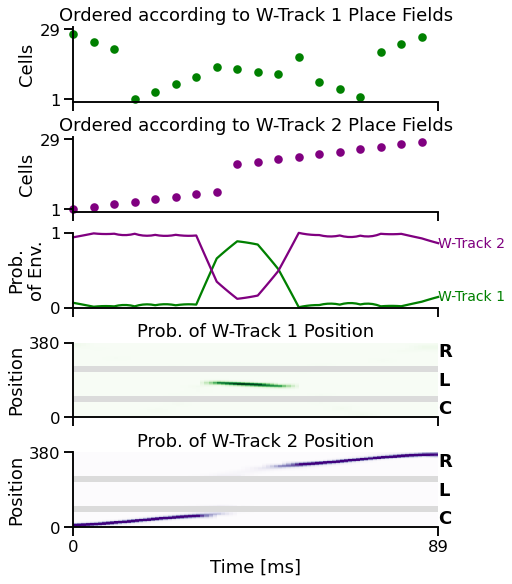

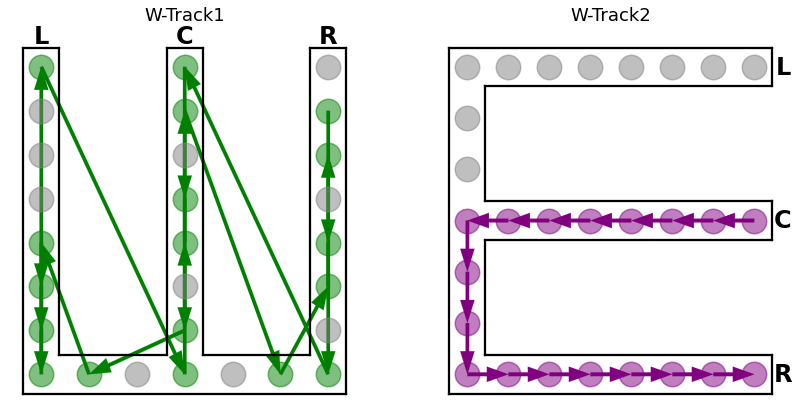

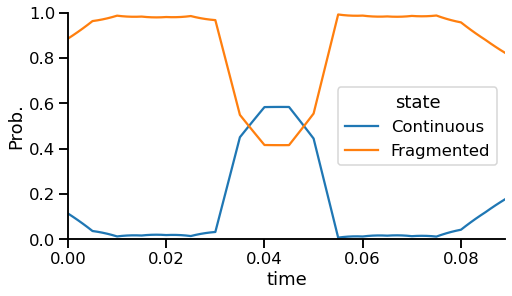

In [19]:
sequence = [26, 23, 20, 17, 14, 11, 8, 3, 2, 1, 0, 7, 10, 13, 16, 19, 22, 25]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


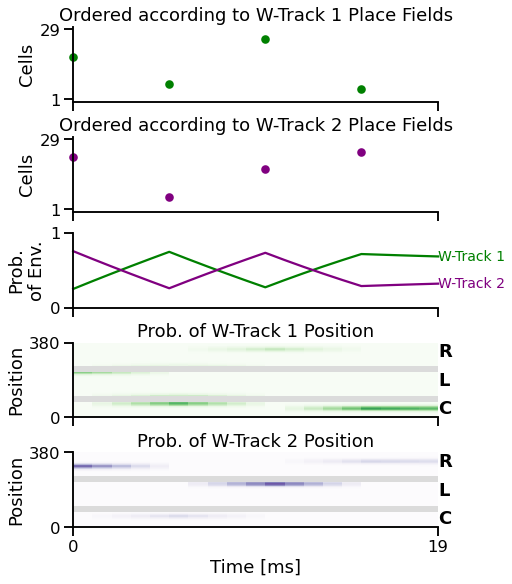

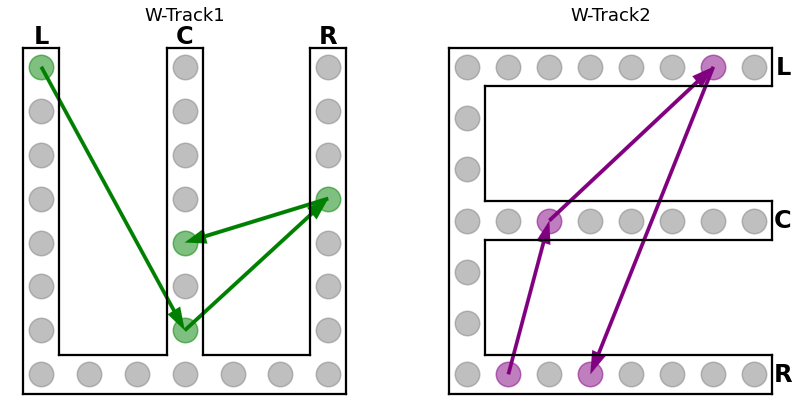

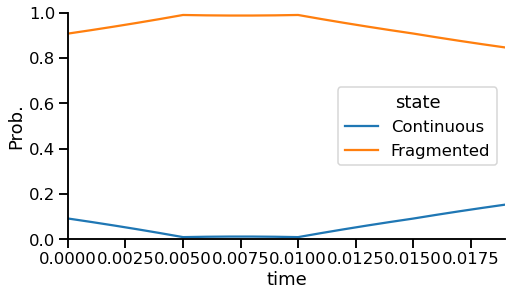

In [20]:
sequence = [7, 11, 24, 13]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


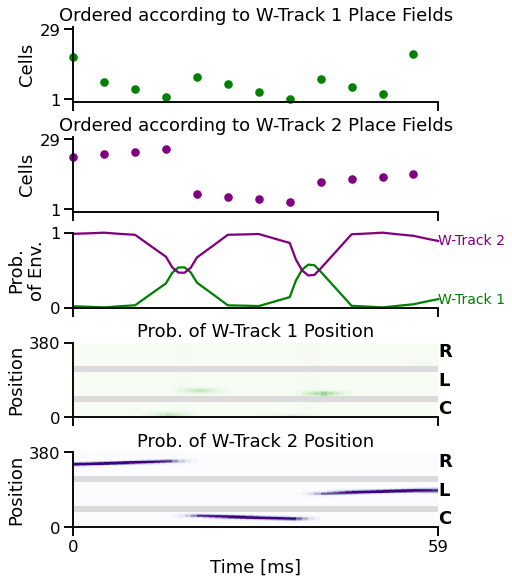

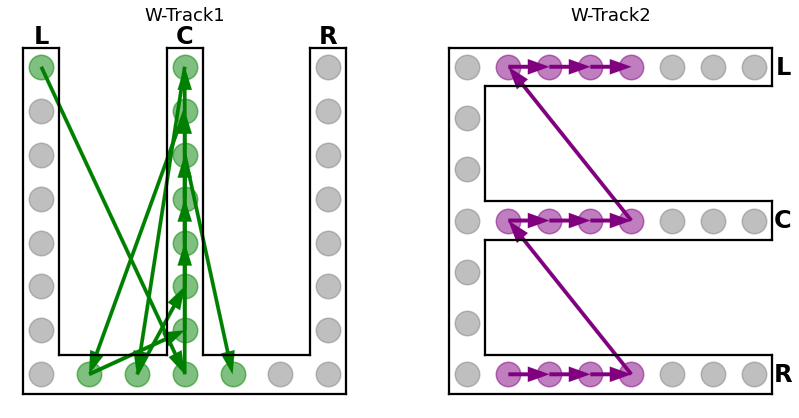

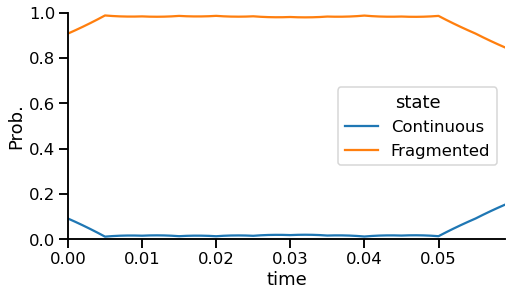

In [21]:
sequence = [7, 10, 13, 16, 8, 11, 14, 17, 9, 12, 15, 18]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


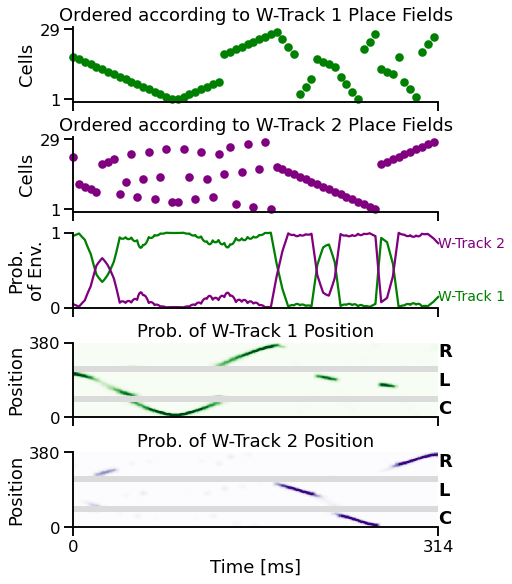

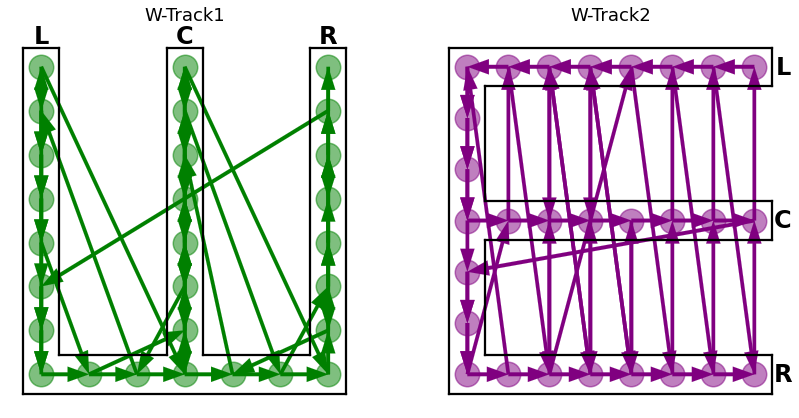

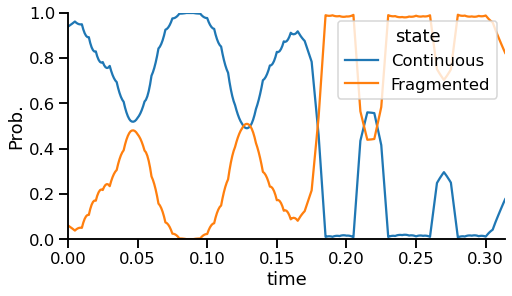

In [22]:
sequence = [7, 6, 5, 4, 3, 2, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
            17, 16, 15, 14, 13, 12, 11, 10, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
            24, 21, 18, 15, 12, 9, 6, 5, 4, 3, 8, 11, 14, 17, 20, 23, 26, 2, 1, 0,
            7, 10, 13, 16, 19, 22, 25]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)